In [49]:
import numpy as np
import aisuite as ai
import re
from typing import Optional, Tuple
import sys
import os

# Correct import for MMPretrain inferencer
from mmpretrain.apis import ImageClassificationInferencer

path = os.path.abspath("../classification/")
print(path)
sys.path.insert(0, str(path))
from cleanlab import Datalab
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from pathlib import Path
import json

/Users/jeremyong/Desktop/research_agent/classification


In [52]:
from mmengine.config import Config
from mmengine.runner import Runner
from mmpretrain.datasets import build_dataset
import torch

class CleaningAgent:
    def __init__(self, 
                 model_name: str, 
                 config_path: str = '../classification/classification_models/configs/tinynet_mixup_imagewoof.py',
                 checkpoint_path: str = None):
        """
        Initialize the CleaningAgent.
        
        Args:
            model_name: LLM model name for aisuite (e.g., 'openai:gpt-4')
            config_path: Path to MMPretrain config file
            checkpoint_path: Path to model checkpoint (optional)
        """
        self.client = ai.Client()
        self.model_name = model_name
        self.config_path = config_path
        self.checkpoint_path = checkpoint_path
        
        # Load config
        self.cfg = Config.fromfile(config_path)
        
        self.system_prompt = """
        You are an expert data engineer in the field of computer vision.
        You are given a dataset from a python Dataloader.
        You need to clean the dataset by removing the following: 
        1. Images that have noisy labels.
        2. Outliers in the dataset.
        3. Duplicates or near duplicates in the dataset.
        4. Images with low entropy.
        """


        self.embedding_model = ImageClassificationInferencer(
            model=config_path,
            pretrained=checkpoint_path,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
            
    
    def load_dataset(self, split='train'):
        """
        Load dataset from config using MMEngine's Runner.
        
        Args:
            split: 'train' or 'val'
            
        Returns:
            dataset: MMPretrain dataset
            dataloader: MMEngine DataLoader (handles DataSample objects)
        """
        runner = Runner.from_cfg(self.cfg)
        
        if split == 'train':
            dataloader = runner.train_dataloader
            dataset = runner.train_dataloader.dataset
        elif split == 'val':
            dataloader = runner.val_dataloader
            dataset = runner.val_dataloader.dataset
        else:
            raise ValueError(f"split must be 'train' or 'val', got {split}")
        
        return dataset, dataloader
    
    def compute_embeddings(self, dataset):
        """
        Compute embeddings for all images in the dataset.
        
        Args:
            dataset: MMPretrain dataset (not dataloader!)
            
        Returns:
            embeddings: numpy array of shape (N, embedding_dim)
            labels: numpy array of shape (N,)
        """
        embeddings_list = []
        pred_probs_list = []
        label_list = []
        preprocessor = self.embedding_model.model.data_preprocessor
        backbone = self.embedding_model.model.backbone
        neck = self.embedding_model.model.neck
        head = self.embedding_model.model.head

        with torch.no_grad():
            for i in range(len(dataset)):
                if i % 100 == 0:
                    print(f"Processing sample {i}/{len(dataset)}...")
                
                sample = dataset[i]
                img = sample['inputs'].unsqueeze(0)
                preprocessed_img = preprocessor(
                    {'inputs': img},
                    training = False
                )
                backbone_output = backbone(preprocessed_img['inputs'])
                image_embeddings = backbone_output[0].squeeze(0).permute(1,2,0).cpu().numpy()
                neck_output = neck(backbone_output)
                head_output = head(neck_output)
                probabilities = F.softmax(head_output, dim=1)
                pred_probs_list.append(probabilities.cpu().numpy())
                embeddings_list.append(image_embeddings)
                label_list.append(sample['data_samples'].gt_label.item())
        pred_probs = np.array(pred_probs_list).squeeze()
        embeddings = np.array(embeddings_list)
        labels = np.array(label_list)
        return embeddings, pred_probs, labels
        
    def clean_dataset(self, dataset, output_directory):
        """
        Clean the dataset using cleanlab's find_label_issues (simpler, no Datalab).
        """
        from cleanlab.filter import find_label_issues
        
        embeddings, pred_probs, labels = self.compute_embeddings(dataset)
        issue_indices = find_label_issues(
            labels=labels,
            pred_probs=pred_probs,
            return_indices_ranked_by='self_confidence'
        )
        
        self.save_clean_dataset(issue_indices, dataset, output_directory)
        return clean_mask, issue_indices

    def save_clean_dataset(self, issue_indices, dataset, output_path):
        """
        Generate metadata for the dataset.
        """
        issue_file_path = []
        output_path = Path(output_path) / "clean_dataset.json"
        with open(output_path, 'w') as f:
            for i in issue_indices:
                full_image_path = dataset[i]['data_samples'].img_path
                image_path = full_image_path.split("/")
                image_path = "/".join(image_path[5:])
                issue_file_path.append(image_path)
                
            metadata = {
                "total_samples": len(dataset),
                "clean_samples": len(dataset) - len(issue_indices),
                "issue_indices": list(issue_indices),
                "issue_file_path": issue_file_path,
            }
            json.dump(metadata,f)

In [53]:
cleaning_agent = CleaningAgent(
    model_name = 'openai:gpt-4',
    config_path = '/Users/jeremyong/Desktop/research_agent/classification/classification_models/configs/tinynet_mixup_imagewoof.py',
    checkpoint_path = '/Users/jeremyong/Desktop/research_agent/classification/classification_models/work_dirs/epoch_120.pth'
)

cleaning_agent.clean_dataset(train_dataset, '/Users/jeremyong/Desktop/research_agent/classification/classification_models/configs')

01/04 23:11:39 - mmengine - INFO - Because batch augmentations are enabled, the data preprocessor automatically enables the `to_onehot` option to generate one-hot format labels.
01/04 23:11:40 - mmengine - INFO - backbone feature_info[0]: {'stage': 1, 'reduction': 2, 'module': 'blocks.0', 'num_chs': 8}
01/04 23:11:40 - mmengine - INFO - backbone feature_info[1]: {'stage': 2, 'reduction': 4, 'module': 'blocks.1', 'num_chs': 16}
01/04 23:11:40 - mmengine - INFO - backbone feature_info[2]: {'stage': 3, 'reduction': 8, 'module': 'blocks.2', 'num_chs': 24}
01/04 23:11:40 - mmengine - INFO - backbone feature_info[3]: {'stage': 5, 'reduction': 16, 'module': 'blocks.4', 'num_chs': 56}
01/04 23:11:40 - mmengine - INFO - backbone feature_info[4]: {'stage': 7, 'reduction': 32, 'module': 'blocks.6', 'num_chs': 160}
Loads checkpoint by local backend from path: /Users/jeremyong/Desktop/research_agent/classification/classification_models/work_dirs/epoch_120.pth
Processing sample 0/12454...
Processing

TypeError: Object of type int64 is not JSON serializable

<DataSample(

META INFORMATION
    ori_shape: (160, 239)
    img_shape: (224, 224, 3)
    flip_direction: horizontal
    img_path: /Users/jeremyong/Desktop/research_agent/dataset/imagewoof-160/train/n02115641/n02115641_2520.JPEG
    flip: True
    sample_idx: 11632

DATA FIELDS
    gt_label: tensor([9])

) at 0x1a4783340>


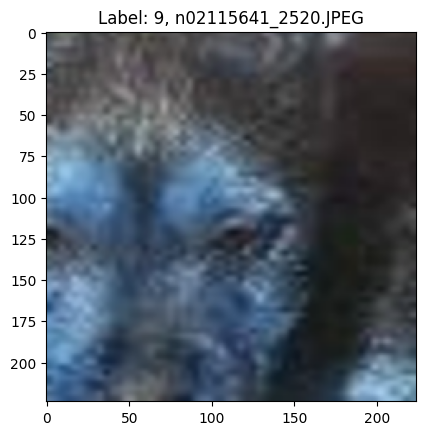

dataset/imagewoof-160/train/n02115641/n02115641_2520.JPEG


In [ ]:
import matplotlib.pyplot as plt
index = 11632
plt.figure()
label = train_dataset[11632]['data_samples'].gt_label.item()
print(train_dataset[11632]['data_samples'])
name = train_dataset[11632]['data_samples'].img_path.split('/')[-1]
plt.imshow(train_dataset[11632]['inputs'].permute(1,2,0).cpu().numpy())
plt.title(f'Label: {label}, {name}')
plt.show()
print("/".join(train_dataset[11632]['data_samples'].img_path.split('/')[5:]))

In [6]:
# Alternative: Simple dataset loading without dataloader complications
# This approach iterates through the dataset directly

from mmengine.config import Config
from mmpretrain.datasets import build_dataset

def simple_load_dataset(config_path, split='train'):
    """
    Simple function to load dataset without dataloader.
    Use this to avoid DataSample collation issues.
    
    Args:
        config_path: Path to config file
        split: 'train' or 'val'
    
    Returns:
        dataset: MMPretrain dataset (iterate with dataset[i])
    """
    cfg = Config.fromfile(config_path)
    
    if split == 'train':
        dataset_cfg = cfg.train_dataloader.dataset
    elif split == 'val':
        dataset_cfg = cfg.val_dataloader.dataset
    else:
        raise ValueError(f"split must be 'train' or 'val'")
    
    dataset = build_dataset(dataset_cfg)
    return dataset

# Example usage
config_path = '../classification/classification_models/configs/tinynet_mixup_imagewoof.py'
train_dataset = simple_load_dataset(config_path, 'train')
val_dataset = simple_load_dataset(config_path, 'val')

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Access individual samples (no batch collation issues!)
sample = train_dataset[0]
print(f"\nSample keys: {list(sample.keys())}")
if 'img' in sample:
    print(f"Image shape: {sample['img'].shape}")
if 'gt_label' in sample:
    print(f"Label: {sample['gt_label']}")


Training samples: 12454
Validation samples: 500

Sample keys: ['inputs', 'data_samples']
